In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

latent = layers.Flatten()(x)
latent = layers.Dense(1024, activation='softmax')(latent)

# Decoder
d = layers.Reshape((4, 4, 64))(latent)
d = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)

decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)

autoencoder = Model(input, decoded)
encoder = Model(input, latent)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496 

In [ ]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
gc.collect()

815

In [ ]:
h = autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=20,
    batch_size=128, 
    shuffle=True,    
    validation_data=(x_test, x_test)
)

Epoch 1/20
391/391 [==============================] - 16s 19ms/step - loss: 0.5941 - val_loss: 0.6790
Epoch 2/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5690 - val_loss: 0.5773
Epoch 3/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5638 - val_loss: 0.5633
Epoch 4/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5616 - val_loss: 0.5609
Epoch 5/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5598 - val_loss: 0.5606
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5588 - val_loss: 0.5602
Epoch 7/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5582 - val_loss: 0.5620
Epoch 8/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5577 - val_loss: 0.5594
Epoch 9/20
391/391 [==============================] - 6s 14ms/step - loss: 0.5573 - val_loss: 0.5588
Epoch 10/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5570 - val_l

In [ ]:
y_pred = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


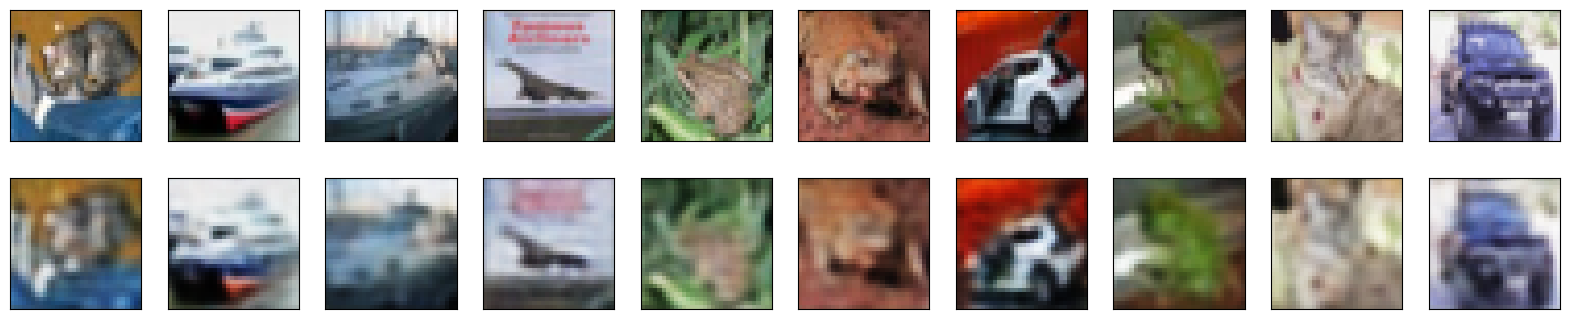

In [ ]:
def display(x1, x2):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x1[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x2[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display(x_test, y_pred)

In [ ]:
features_test = encoder(x_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(features_test, y_test)

<ipython-input-12-a3fcce347d31>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(features_test, y_test)


RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
y_pred = clf.predict(features_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9224

In [ ]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


In [ ]:
denoising_ae = Model(input, decoded, name='denoising')
denoising_encoder = Model(input, latent)

denoising_ae.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
noisy_x_train = noise(x_train)
noisy_x_test = noise(x_test)

In [ ]:
denoising_ae.fit(
    x=noisy_x_train,
    y=x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_x_test, x_test),
)

Epoch 1/20
391/391 [==============================] - 7s 18ms/step - loss: 0.5703 - val_loss: 2.9098
Epoch 2/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5693 - val_loss: 2.9663
Epoch 3/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5689 - val_loss: 0.8710
Epoch 4/20
391/391 [==============================] - 6s 16ms/step - loss: 0.5685 - val_loss: 0.7497
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5683 - val_loss: 0.6757
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5679 - val_loss: 1.8332
Epoch 7/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5676 - val_loss: 0.8035
Epoch 8/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5674 - val_loss: 0.6251
Epoch 9/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5673 - val_loss: 0.5794
Epoch 10/20
391/391 [==============================] - 6s 15ms/step - loss: 0.5670 - val_lo

In [ ]:
features = denoising_encoder(noisy_x_test)
clf.fit(features, y_test)

<ipython-input-20-1473f8c0fd61>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(features, y_test)


RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
y_pred = clf.predict(features)

In [ ]:
accuracy_score(y_test, y_pred)

0.9321